In [ ]:
#Required packages installation; remove # from the following lines
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install xgboost
#!pip3 install scikit-learn

In [1]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

The following section is for data loading and cleaning

In [2]:
# Load dataset into a dataframe
df = pd.read_csv("HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df.head()

# Make a copy of the dataframe
df_new = df.copy()
df_new.info()

# Some statistics about the dataframe
df_new.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [3]:
#Renamning colums 
df_new.columns

df_new = df_new.rename(columns={
    'time_spend_company': 'tenure',
    'Work_accident': 'work_accident',
    'Department': 'department',
    'average_montly_hours': 'average_monthly_hours'
})

# Display all column names after the update
df_new.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [4]:
# Check for missing values
df_new.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [5]:
# Check for duplicates
df_new.duplicated().sum()

np.int64(3008)

In [6]:
# Checking representative rows containing duplicates
duplicates = df_new[df_new.duplicated()].head(n = 10)
print(duplicates)

       satisfaction_level  last_evaluation  number_project  \
396                  0.46             0.57               2   
866                  0.41             0.46               2   
1317                 0.37             0.51               2   
1368                 0.41             0.52               2   
1461                 0.42             0.53               2   
1516                 0.40             0.50               2   
1616                 0.37             0.46               2   
1696                 0.39             0.56               2   
1833                 0.10             0.85               6   
12000                0.38             0.53               2   

       average_monthly_hours  tenure  work_accident  left  \
396                      139       3              0     1   
866                      128       3              0     1   
1317                     127       3              0     1   
1368                     132       3              0     1   
1461        

In [7]:
# Drop duplicates and save resulting dataframe as new
df_clean = df_new.drop_duplicates()

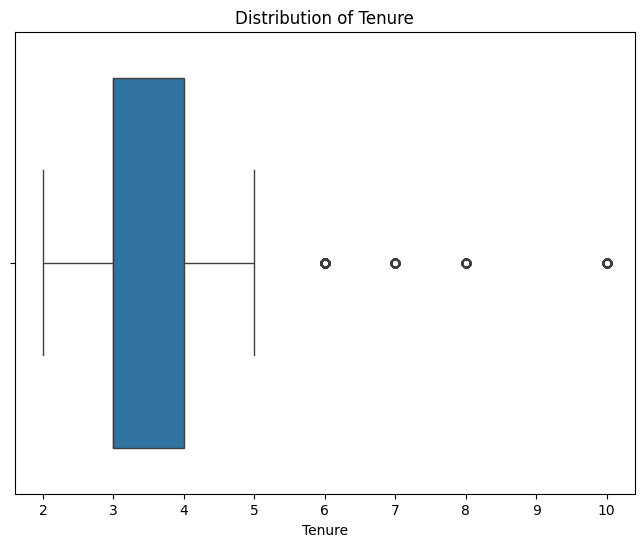

In [8]:
#Checking for outliers via boxplot to visualize distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_clean['tenure'])
plt.xlabel('Tenure')
plt.title('Distribution of Tenure')
plt.show()

In [9]:
# Determine the number of rows containing outliers
# Test threshold for outliers ~ outside 1.5 times the interquartile range
threshold = 1.5

# Calculate the interquartile range (IQR)
q1 = df_clean['tenure'].quantile(0.25)
q3 = df_clean['tenure'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lower_bound = q1 - threshold * iqr
upper_bound = q3 + threshold * iqr

# Count the number of rows containing outliers
outliers_count = df_clean[(df_clean['tenure'] < lower_bound) | (df_clean['tenure'] > upper_bound)].shape[0]

# Display the number of rows containing outliers
print("Number of rows containing outliers in 'tenure':", outliers_count)

Number of rows containing outliers in 'tenure': 824


Number of employees who left vs. stayed:
left
0    10000
1     1991
Name: count, dtype: int64
Percentage of employees who left vs. stayed:
left
0    83.39588
1    16.60412
Name: proportion, dtype: float64


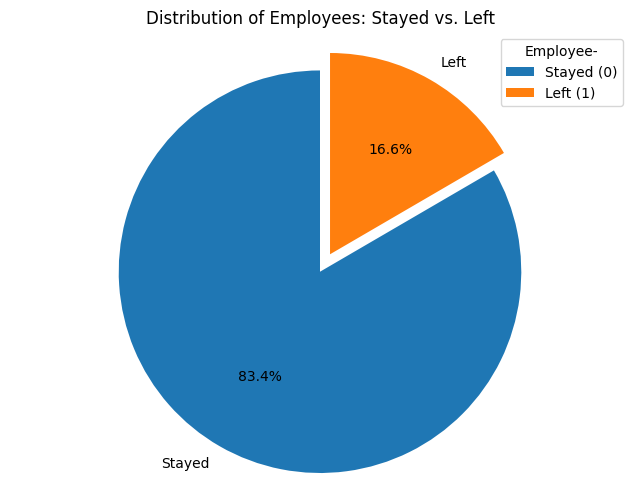

In [11]:
# Get employee churn
attrition_counts = df_clean['left'].value_counts()

# Get percentages of employee churn
attrition_percentages = df_clean['left'].value_counts(normalize=True) * 100

# Display the results
print("Number of employees who left vs. stayed:")
print(attrition_counts)
print("Percentage of employees who left vs. stayed:")
print(attrition_percentages)

#Some more visualization of attrition
# Define labels and colors for the pie chart
labels = ['Stayed', 'Left']
#colors = ['#2ecc71', '#e74c3c']

# Create the advanced pie chart
plt.figure(figsize=(8, 6))
plt.pie(attrition_counts, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Distribution of Employees: Stayed vs. Left')

# Add legend
plt.legend(title='Employee-', labels=['Stayed (0)', 'Left (1)'])

plt.axis('equal')
plt.show()

Exploratory Data Analysis

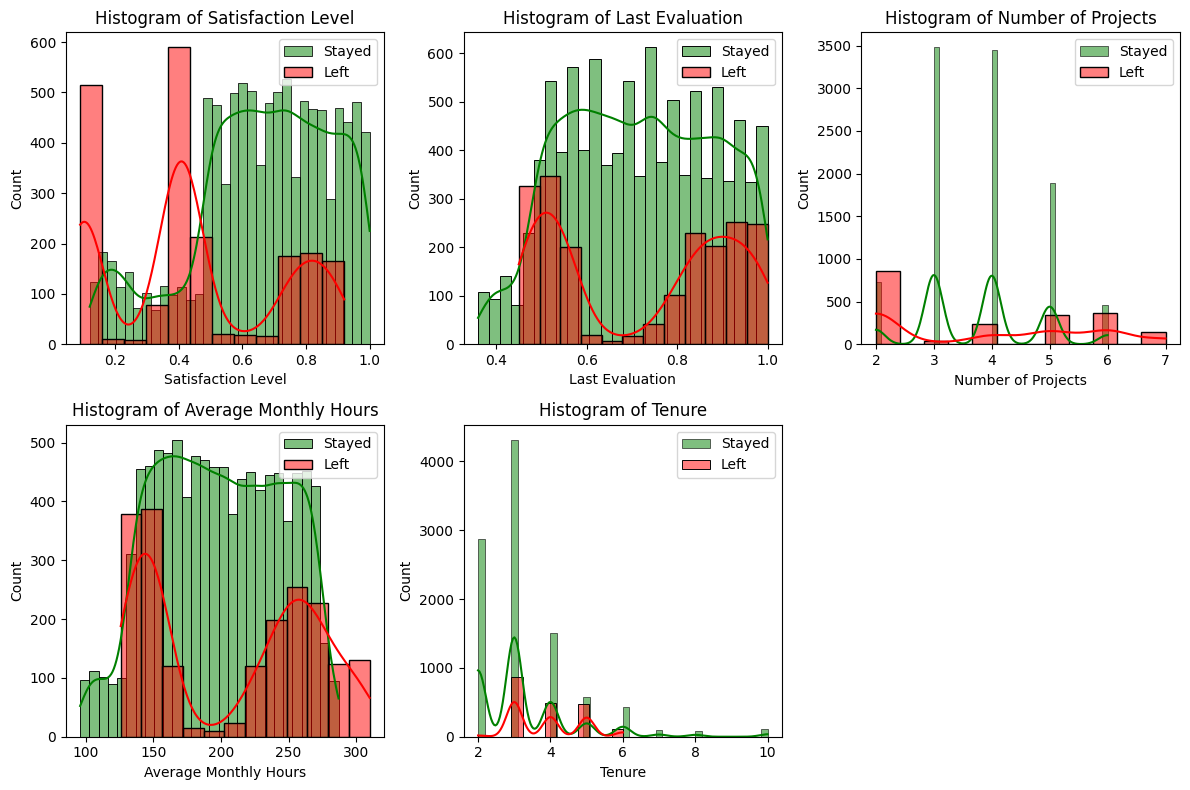

In [12]:
#Testing out data distribution and correlations
plt.figure(figsize=(12, 8))

# Plot histogram for satisfaction_level
plt.subplot(2, 3, 1)
sns.histplot(df_clean[df_clean['left'] == 0]['satisfaction_level'], kde=True, color='green', label='Stayed')
sns.histplot(df_clean[df_clean['left'] == 1]['satisfaction_level'], kde=True, color='red', label='Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Count')
plt.title('Histogram of Satisfaction Level')
plt.legend()

# Plot histogram for last_evaluation
plt.subplot(2, 3, 2)
sns.histplot(df_clean[df_clean['left'] == 0]['last_evaluation'], kde=True, color='green', label='Stayed')
sns.histplot(df_clean[df_clean['left'] == 1]['last_evaluation'], kde=True, color='red', label='Left')
plt.xlabel('Last Evaluation')
plt.ylabel('Count')
plt.title('Histogram of Last Evaluation')
plt.legend()

# Plot histogram for number_project
plt.subplot(2, 3, 3)
sns.histplot(df_clean[df_clean['left'] == 0]['number_project'], kde=True, color='green', label='Stayed')
sns.histplot(df_clean[df_clean['left'] == 1]['number_project'], kde=True, color='red', label='Left')
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.title('Histogram of Number of Projects')
plt.legend()

# Plot histogram for average_monthly_hours
plt.subplot(2, 3, 4)
sns.histplot(df_clean[df_clean['left'] == 0]['average_monthly_hours'], kde=True, color='green', label='Stayed')
sns.histplot(df_clean[df_clean['left'] == 1]['average_monthly_hours'], kde=True, color='red', label='Left')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Count')
plt.title('Histogram of Average Monthly Hours')
plt.legend()

# Plot histogram for tenure
plt.subplot(2, 3, 5)
sns.histplot(df_clean[df_clean['left'] == 0]['tenure'], kde=True, color='green', label='Stayed')
sns.histplot(df_clean[df_clean['left'] == 1]['tenure'], kde=True, color='red', label='Left')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Histogram of Tenure')
plt.legend()

plt.tight_layout()
plt.show()

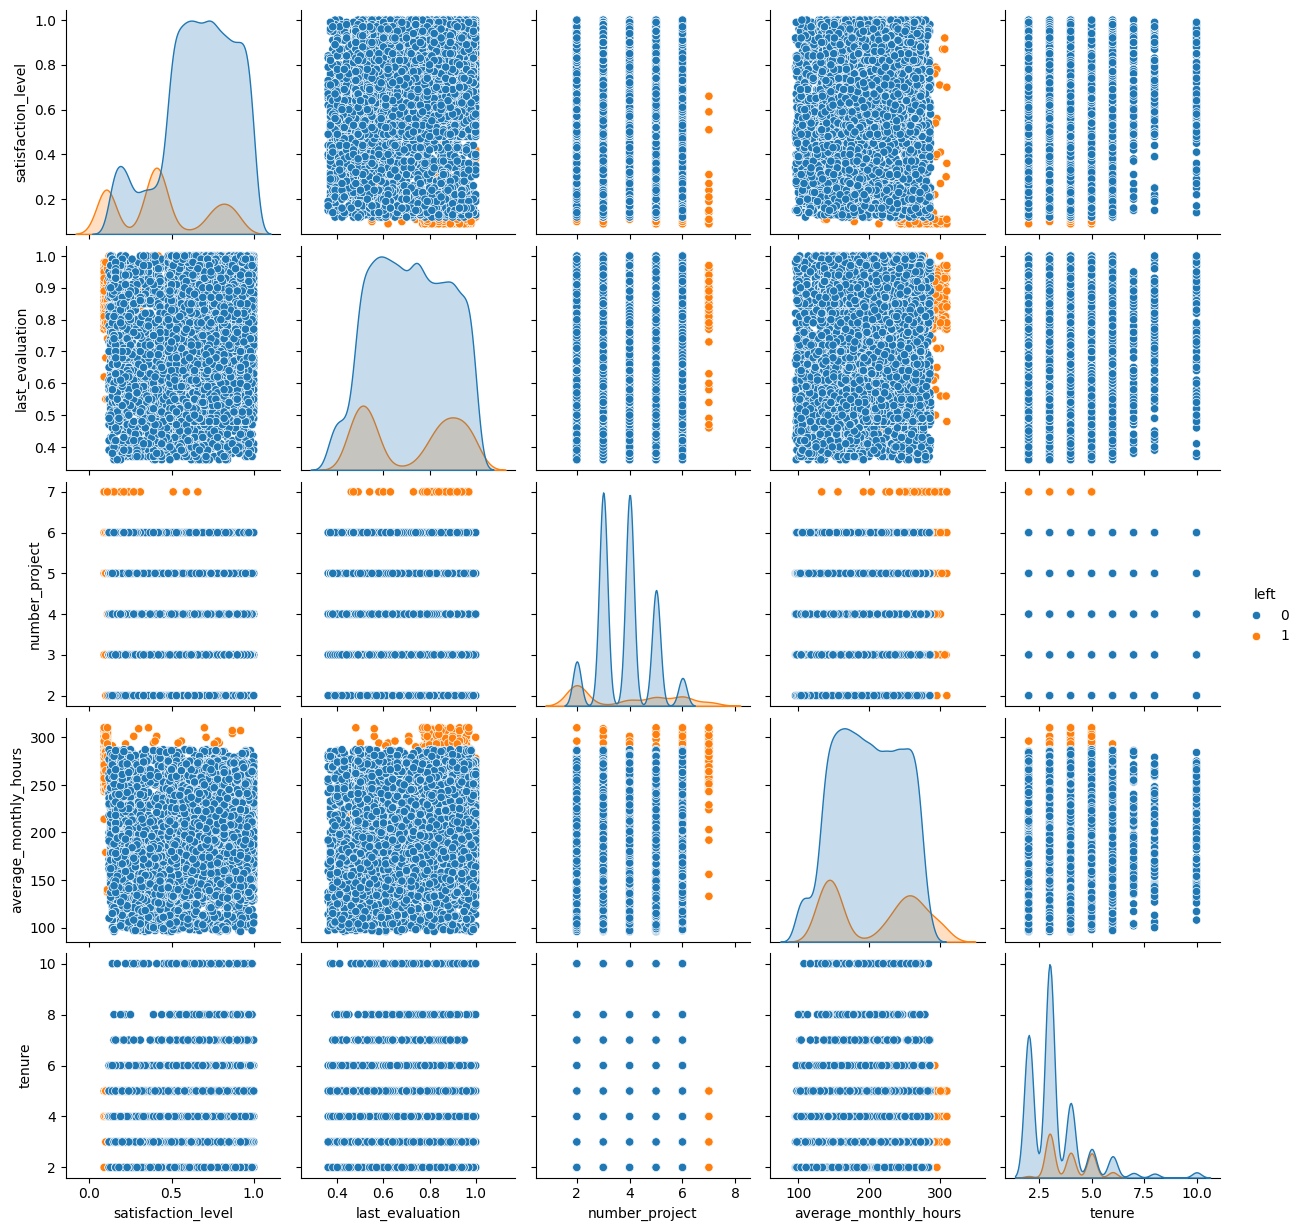

In [14]:
#Another pairplot to see correlation

nums = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']
bnry = ['work_accident', 'promotion_last_5years']
cats = ['department', 'salary']
TARGET = ['left']

sns.pairplot(data=df_clean[nums + TARGET], hue='left')
plt.show()

Most of the 'left' distribution in each numerical variables that are shown in histogram are overlapping except for the low 'satisfaction level' and high 'average_monthly_hours' where the employees who left the company are more than the employees who stayed.
Using tree-based models might be a good choice.
No linear relationship between any of the numerical variables.

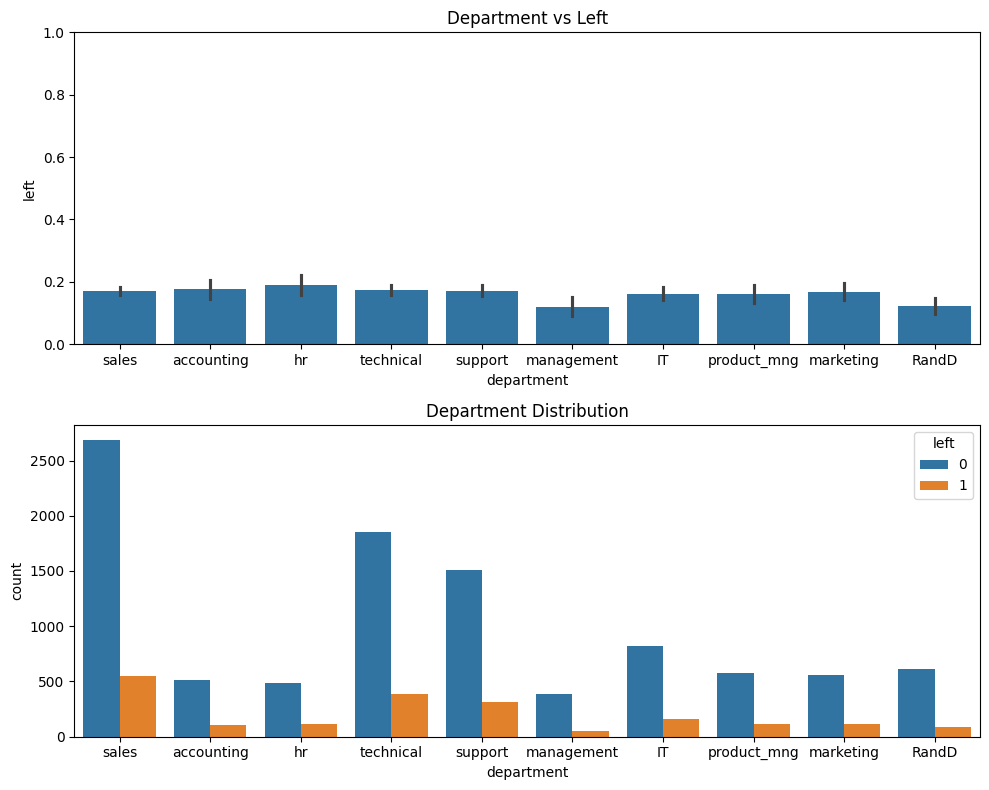

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# barplot satisfaction level vs. left
sns.barplot(x=df_clean['department'], y=df_clean['left'], ax=ax[0])
ax[0].set_ylim(0, 1)
ax[0].set_title('Department vs Left')

# countplot department distribution
sns.countplot(x=df_clean['department'], hue=df_clean['left'], ax=ax[1])
ax[1].set_title('Department Distribution')

plt.tight_layout()
plt.show()

No correlation with department and personemployee attrition

C:\Users\Daksh\AppData\Local\Temp\ipykernel_22524\2290365009.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_rate = df_clean.groupby(bins)['left'].mean() * 100


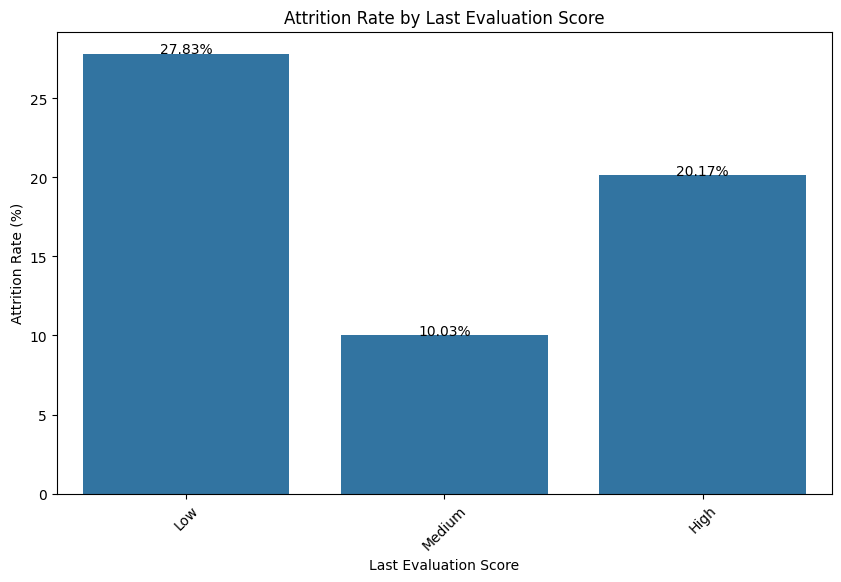

In [17]:
# Create bins for different ranges of last evaluation scores
bins = pd.cut(df_clean['last_evaluation'], bins=[0, 0.5, 0.75, 1], labels=['Low', 'Medium', 'High'])

# Calculate the attrition rate for each bin
attrition_rate = df_clean.groupby(bins)['left'].mean() * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=attrition_rate.index, y=attrition_rate.values)
plt.xlabel('Last Evaluation Score')
plt.ylabel('Attrition Rate (%)')
plt.title('Attrition Rate by Last Evaluation Score')

for i, value in enumerate(attrition_rate.values):
    plt.text(i, value, f'{value:.2f}%', ha='center')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.show()

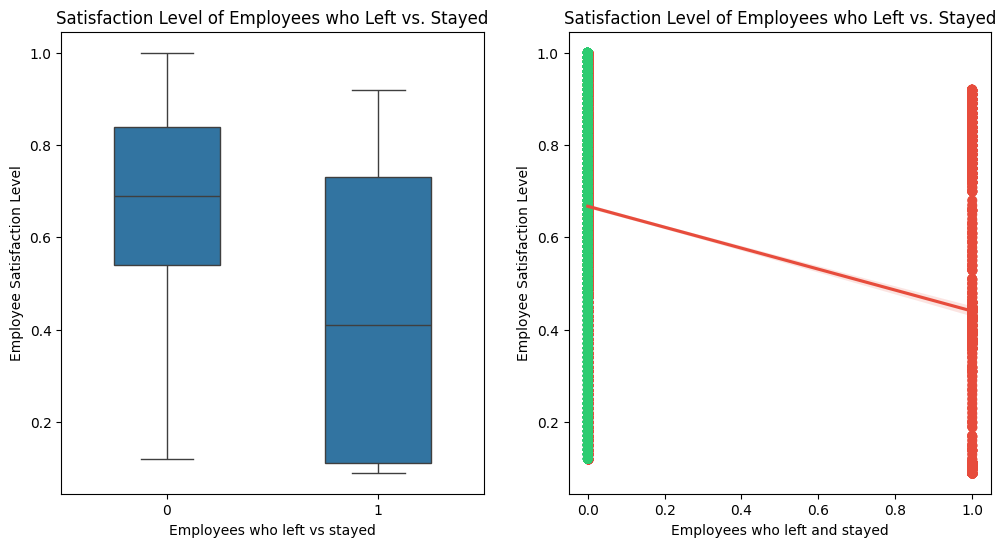

<Figure size 640x480 with 0 Axes>

In [18]:
#Plotting employee satisfaction vs. attrition

plt.figure(figsize=(12, 6))

# Create a dictionary to map colors to the 'left' categories
left_colors = {0: '#2ecc71', 1: '#e74c3c'}

# Box plot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_clean['left'], y=df_clean['satisfaction_level'], width=0.5)
plt.xlabel('Employees who left vs stayed')
plt.ylabel('Employee Satisfaction Level')
plt.title('Satisfaction Level of Employees who Left vs. Stayed')
# Regplot


# Plot the regplot
plt.subplot(1, 2, 2)
sns.regplot(x='left', y='satisfaction_level', data=df_clean, color=left_colors[1])
plt.scatter(x='left', y='satisfaction_level', data=df_clean, c=df_clean['left'].map(left_colors))
plt.xlabel('Employees who left and stayed')
plt.ylabel('Employee Satisfaction Level')
plt.title('Satisfaction Level of Employees who Left vs. Stayed')
plt.show()



plt.tight_layout()
plt.show()

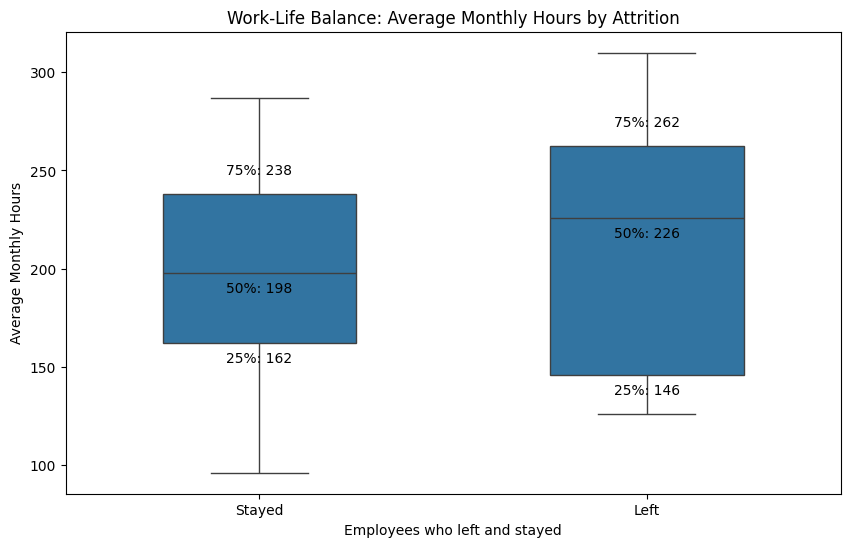

In [19]:
#compare the distribution of average monthly hours for employees who left the company versus those who stayed
plt.figure(figsize=(10, 6))

# Create box plot with color-coded boxes
sns.boxplot(x=df_clean['left'], y=df_clean['average_monthly_hours'], width=0.5)

# Set labels and title
plt.xlabel('Employees who left and stayed')
plt.ylabel('Average Monthly Hours')
plt.title('Work-Life Balance: Average Monthly Hours by Attrition')

# Add statistical annotations
stats = df_clean.groupby('left')['average_monthly_hours'].describe()
for i, label in enumerate(stats.index):
    plt.text(i, stats.loc[label, '75%'] + 10, f"75%: {int(stats.loc[label, '75%'])}", ha='center', color='black')
    plt.text(i, stats.loc[label, '50%'] - 10, f"50%: {int(stats.loc[label, '50%'])}", ha='center', color='black')
    plt.text(i, stats.loc[label, '25%'] - 10, f"25%: {int(stats.loc[label, '25%'])}", ha='center', color='black')

plt.xticks(ticks=[0, 1], labels=['Stayed', 'Left'])


plt.show()

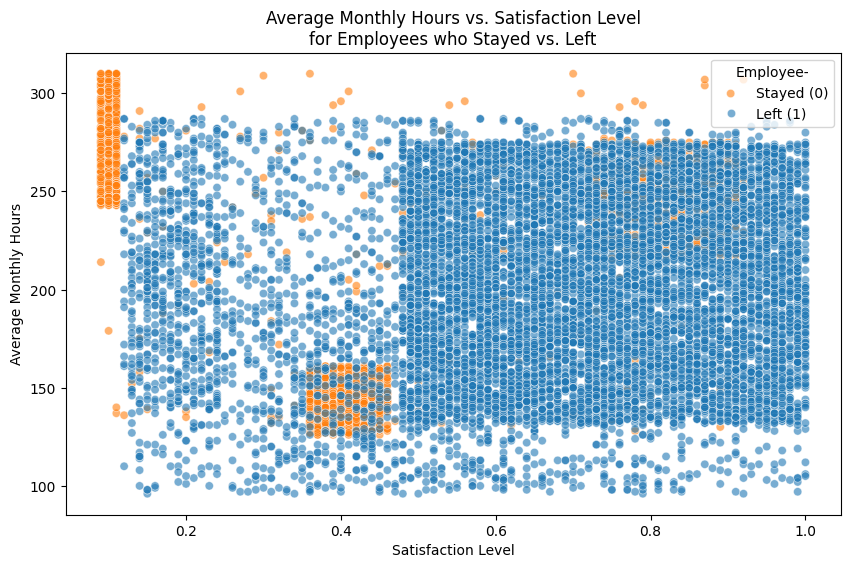

In [20]:
plt.figure(figsize=(10, 6))

# Create scatter plot comparing employees who stayed versus those who left
sns.scatterplot(x='satisfaction_level', y='average_monthly_hours', hue='left', data=df_clean, alpha=0.6)

# Set labels and title
plt.xlabel('Satisfaction Level')
plt.ylabel('Average Monthly Hours')
plt.title('Average Monthly Hours vs. Satisfaction Level\nfor Employees who Stayed vs. Left')

# Add legend
plt.legend(title='Employee-', labels=['Stayed (0)', 'Left (1)'])

plt.show()

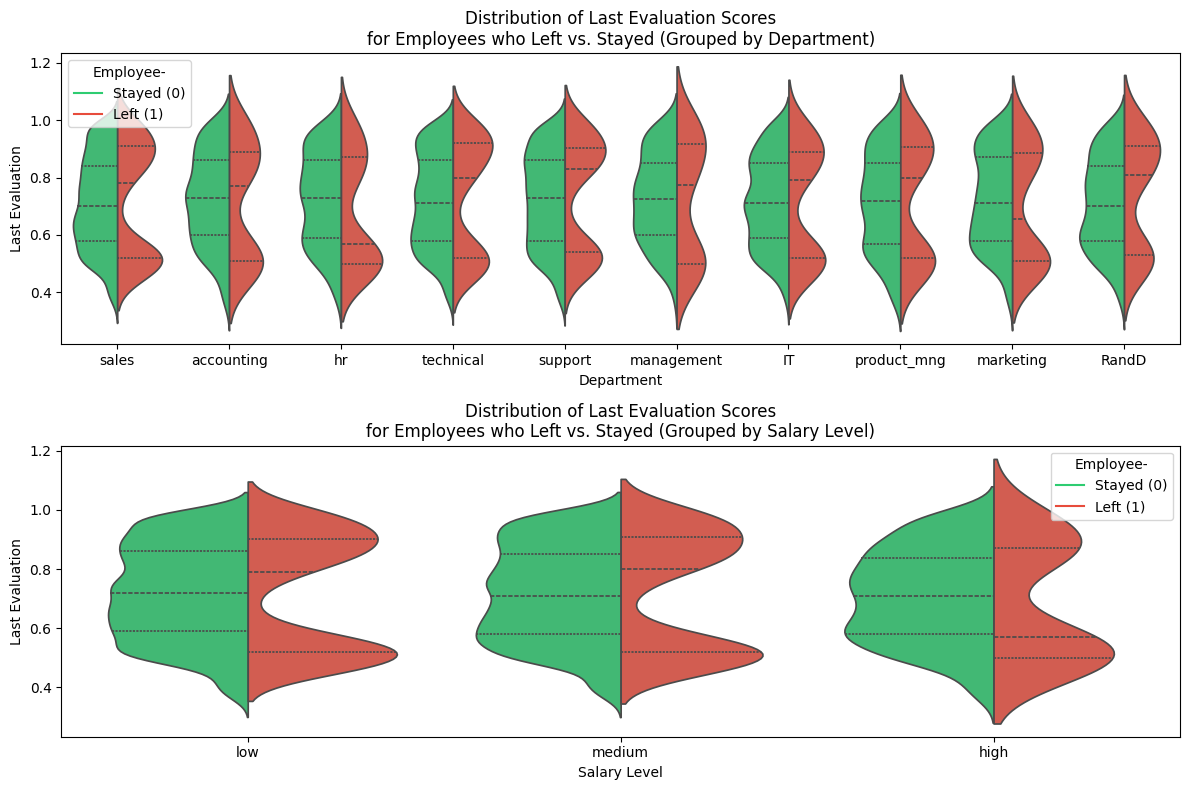

In [21]:
# Create violin plot comparing last evaluation scores for employees who left versus stayed, grouped by department
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.violinplot(x='department', y='last_evaluation', hue='left', data=df_clean, split=True, inner='quartile', palette={0: '#2ecc71', 1: '#e74c3c'})

# Create custom legend elements
legend_elements = [
    plt.Line2D([0], [0], color='#2ecc71', label='Stayed (0)'),
    plt.Line2D([0], [0], color='#e74c3c', label='Left (1)'),
]

# Add the custom legend elements to the plot
plt.legend(handles=legend_elements, title='Employee-')

plt.xlabel('Department')
plt.ylabel('Last Evaluation')
plt.title('Distribution of Last Evaluation Scores\nfor Employees who Left vs. Stayed (Grouped by Department)')

# Create violin plot comparing last evaluation scores for employees who left versus stayed, grouped by salary level
plt.subplot(2, 1, 2)
sns.violinplot(x='salary', y='last_evaluation', hue='left', data=df_clean, split=True, inner='quartile', palette={0: '#2ecc71', 1: '#e74c3c'})

# Add the custom legend elements to the plot
plt.legend(handles=legend_elements, title='Employee-')

plt.xlabel('Salary Level')
plt.ylabel('Last Evaluation')
plt.title('Distribution of Last Evaluation Scores\nfor Employees who Left vs. Stayed (Grouped by Salary Level)')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

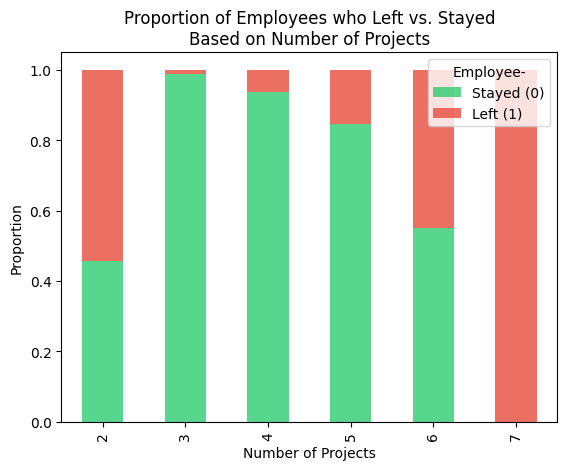

In [22]:
plt.figure(figsize=(10, 6))

# Calculate the proportion of employees who left versus stayed based on project counts
project_counts = df_clean.groupby(['number_project', 'left']).size().unstack()
project_counts['Total'] = project_counts.sum(axis=1)
project_proportions = project_counts.div(project_counts['Total'], axis=0)

# Create the stacked bar plot
project_proportions[[0, 1]].plot(kind='bar', stacked=True, color=['#2ecc71', '#e74c3c'], alpha=0.8)

# Set labels and title
plt.xlabel('Number of Projects')
plt.ylabel('Proportion')
plt.title('Proportion of Employees who Left vs. Stayed\nBased on Number of Projects')

# Add legend
plt.legend(title='Employee-', labels=['Stayed (0)', 'Left (1)'])

plt.show()

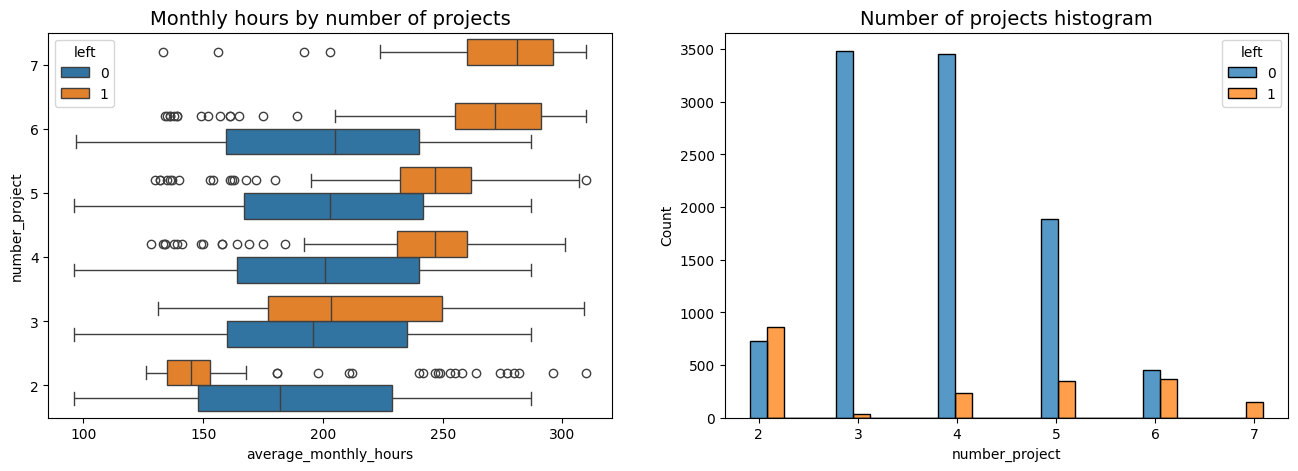

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (16,5))

sns.boxplot(data=df_clean, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

tenure_stay = df_clean[df_clean['left']==0]['number_project']
tenure_left = df_clean[df_clean['left']==1]['number_project']
sns.histplot(data=df_clean, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()


C:\Users\Daksh\AppData\Local\Temp\ipykernel_22524\3498347025.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = count / total_counts[i] * 100


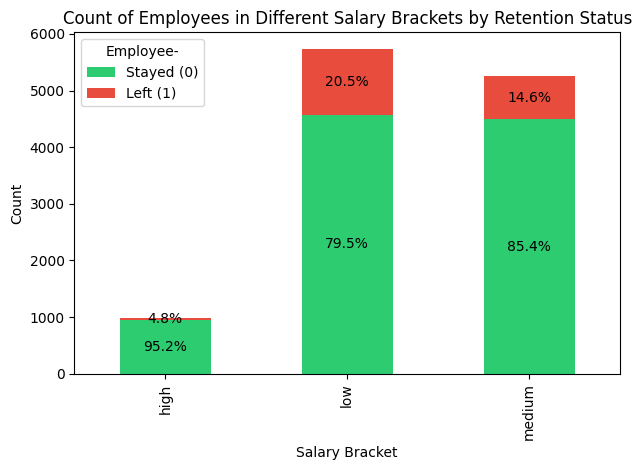

In [23]:
# Count the number of employees in each salary bracket
salary_count = df_clean.groupby(['salary', 'left']).size().unstack()

# Set the colors for employees who stayed and left
colors = ['#2ecc71', '#e74c3c']

# Create the grouped bar plot
salary_count.plot(kind='bar', stacked=True, color=colors)

# Add labels, title, and legend
plt.xlabel('Salary Bracket')
plt.ylabel('Count')
plt.title('Count of Employees in Different Salary Brackets by Retention Status')
plt.legend(title='Employee-', labels=['Stayed (0)', 'Left (1)'])

# Add percentage labels on top of each bar
total_counts = salary_count.sum(axis=1)
for i, (index, row) in enumerate(salary_count.iterrows()):
    for j, count in enumerate(row):
        percentage = count / total_counts[i] * 100
        plt.text(i, row[:j].sum() + count / 2, f'{percentage:.1f}%', ha='center', va='center')

plt.tight_layout()
plt.show()

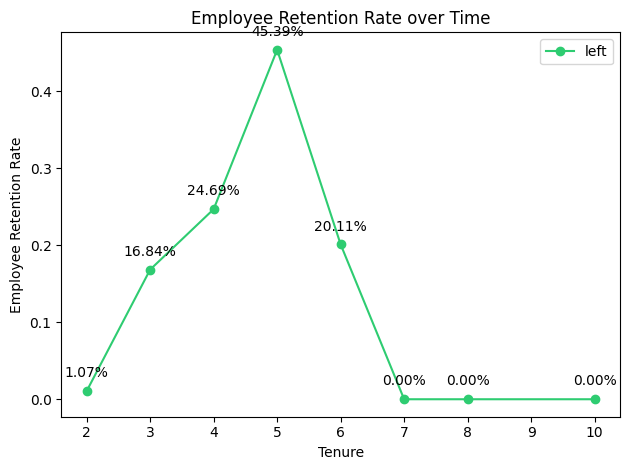

In [24]:
# Group the data by tenure and calculate the turnover rate
turnover_rate = df_clean.groupby('tenure')['left'].mean()

# Create the line plot
turnover_rate.plot(marker='o', linestyle='-', color='#2ecc71')
plt.xlabel('Tenure')
plt.ylabel('Employee Retention Rate')
plt.title('Employee Retention Rate over Time')
plt.legend()

# Annotate each data point with its turnover rate
for x, y in zip(turnover_rate.index, turnover_rate.values):
    plt.annotate(f'{y:.2%}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', color='black')

plt.tight_layout()
plt.show()

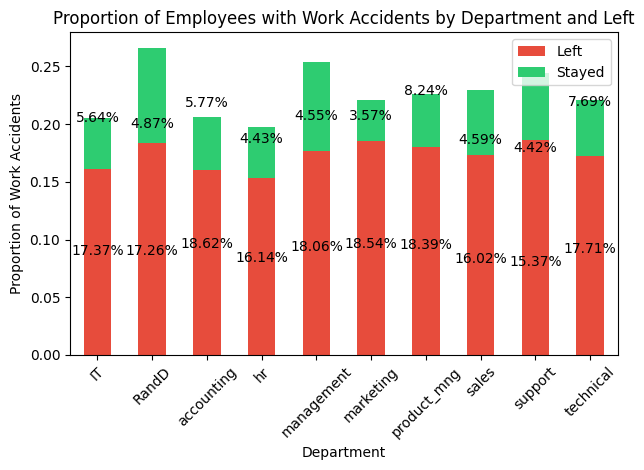

In [25]:
# Group the data by department and left, and calculate the proportion of work accidents
work_accident_prop = df_clean.groupby(['department', 'left'])['work_accident'].mean().unstack()

# Set the order of departments
department_order = ['sales', 'technical', 'support', 'IT', 'product_mng', 'marketing', 'RandD', 'accounting', 'hr', 'management']

# Create the grouped bar plot
work_accident_prop.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
plt.xlabel('Department')
plt.ylabel('Proportion of Work Accidents')
plt.title('Proportion of Employees with Work Accidents by Department and Left')
plt.xticks(rotation=45)
plt.legend(['Left', 'Stayed'])

# Add the proportion labels for each bar
for i, department in enumerate(department_order):
    left_prop = work_accident_prop.loc[department, 1]
    stayed_prop = work_accident_prop.loc[department, 0]
    plt.text(i, stayed_prop / 2, f'{stayed_prop:.2%}', ha='center', color='black')
    plt.text(i, stayed_prop + left_prop / 2, f'{left_prop:.2%}', ha='center', color='black')

plt.tight_layout()
plt.show()


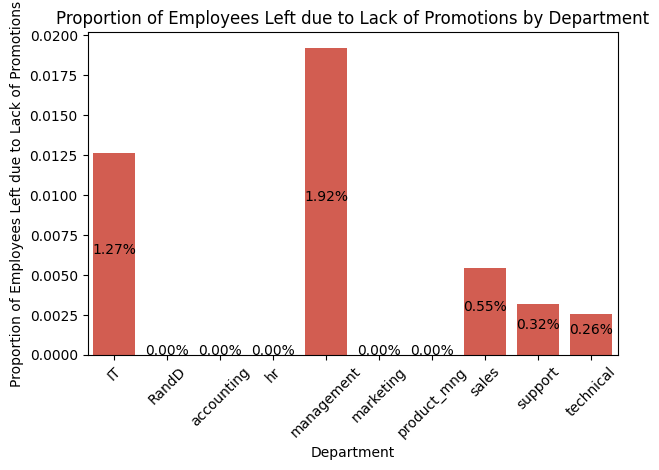

In [26]:
# Group the data by department and left, and calculate the proportion of employees who left due to lack of promotions
promotion_prop = df_clean[df_clean['left'] == 1].groupby('department')['promotion_last_5years'].mean().reset_index()

# Set the order of departments
department_order = ['sales', 'technical', 'support', 'IT', 'product_mng', 'marketing', 'RandD', 'accounting', 'hr', 'management']

# Create the stacked bar plot using Seaborn
sns.barplot(data=promotion_prop, x='department', y='promotion_last_5years', color='#e74c3c')

plt.xlabel('Department')
plt.ylabel('Proportion of Employees Left due to Lack of Promotions')
plt.title('Proportion of Employees Left due to Lack of Promotions by Department')
plt.xticks(rotation=45)

# Add the proportion labels for each bar
for i, row in promotion_prop.iterrows():
    prop = row['promotion_last_5years']
    plt.text(i, prop / 2, f'{prop:.2%}', ha='center', color='black')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Monthly hours by last evaluation score')

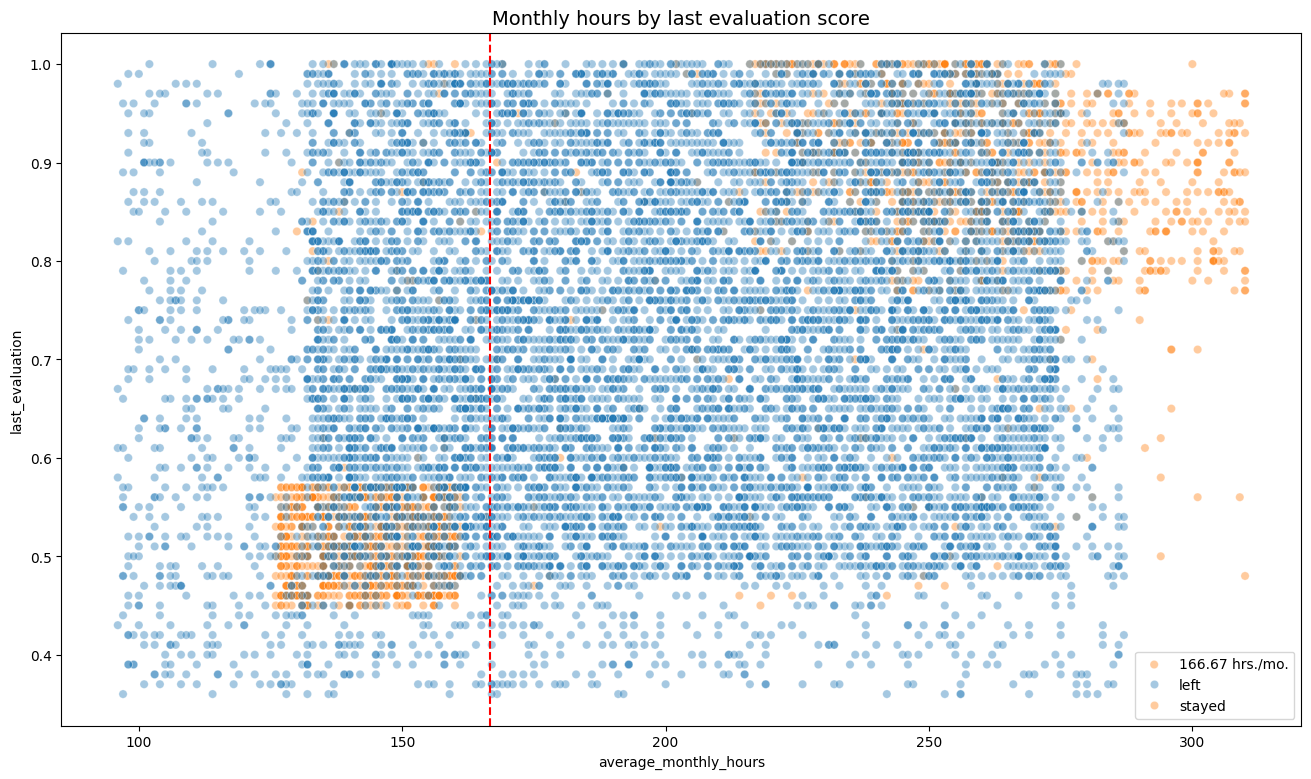

In [31]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df_clean, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='red', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14')


There are group of employee with low last_evaluation with normal working hours (~150 hours) and left the company.
There are group of employee with high last_evaluation with high working hours (~250+ hours) and left the company - overworking.

Text(0.5, 1.0, 'Monthly hours by promotion last 5 years')

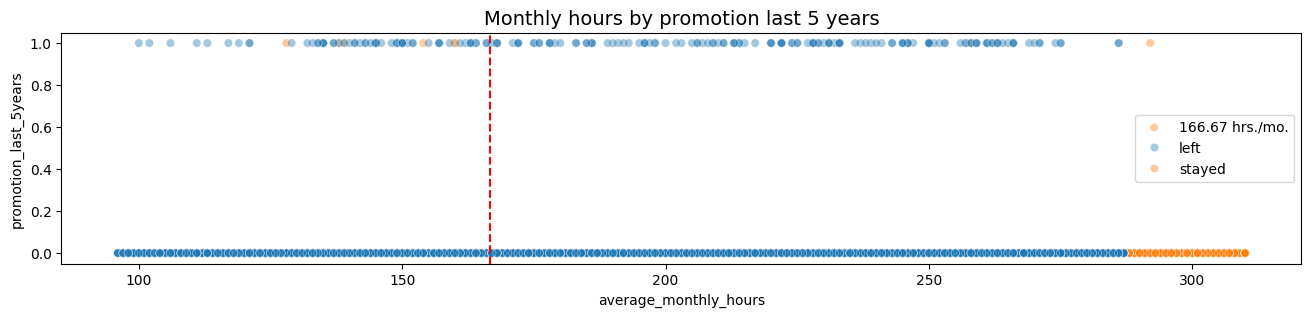

In [32]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df_clean, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='red', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14')


Few employees who were promoted in the last 5 years left the company.
Few employees who worked the most hours were promoted.
Most of the employees who left the company were working the most hours and were not promoted.

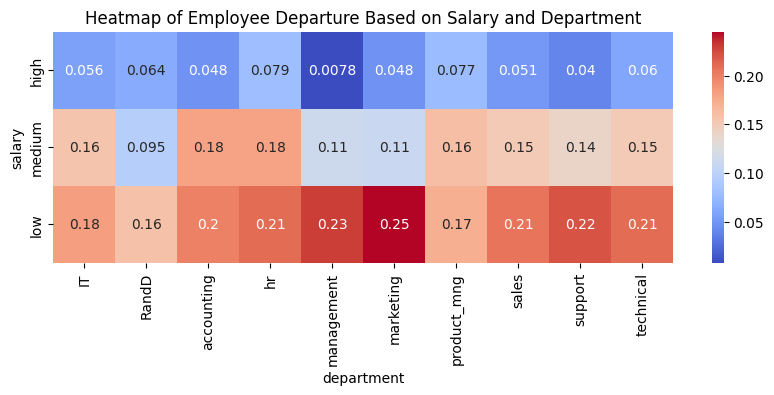

In [27]:
temp = df_clean.groupby(['department', 'salary'])['left'].mean()
temp = pd.DataFrame(temp).reset_index()
temp = temp.pivot_table(index='salary', columns='department', values='left')
temp = temp.reindex(['high', 'medium', 'low'])
plt.figure(figsize=(10,3))
sns.heatmap(temp, cmap='coolwarm', annot=True)
plt.title('Heatmap of Employee Departure Based on Salary and Department')
plt.show()

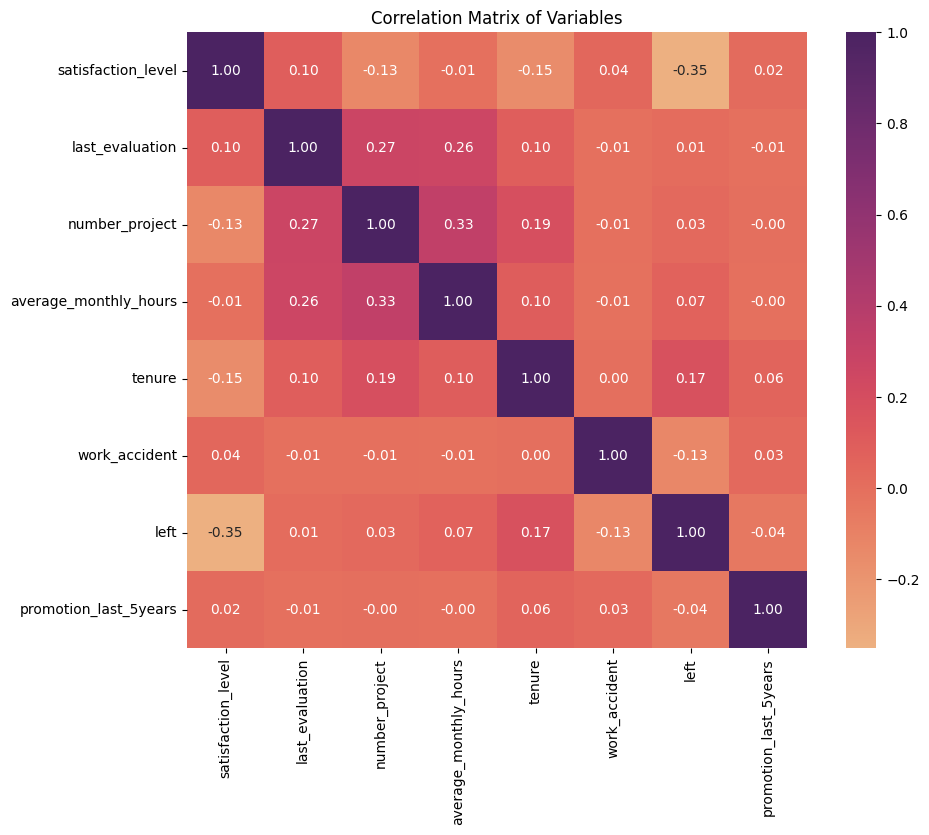

In [28]:
#Overall Correlation Matrix

corr_matrix = df_clean.corr(numeric_only=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='flare', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

The correlation confirms that number_project and average_monthly_hours are positively correlated.
left is negatively correlated with satisfaction_level.

Checking data balance for the dataframe before modeling

In [34]:
# Count the occurrences of each class in the 'left' column
data_balance = df_clean['left'].value_counts()

# Calculate the percentage of each class
data_balance_percentage = data_balance / len(df_clean) * 100

print("Data Balance:")
print(data_balance)
print("Data Balance Percentage:")
print(data_balance_percentage)

Data Balance:
left
0    10000
1     1991
Name: count, dtype: int64
Data Balance Percentage:
left
0    83.39588
1    16.60412
Name: count, dtype: float64


#--------------------------------------------------------------------------#
Model Building Phase
We will try Logical regression, Tree Based, and Gradient Boosting

In [33]:
df_encoded = df_clean.copy()
df_encoded['salary'] = df_encoded['salary'].map({'high': 2,
                                                 'medium': 1,
                                                 'low': 0})
df_encoded = pd.get_dummies(df_encoded, columns=['department'])
df_encoded.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
1       6              0     1                      0       1          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

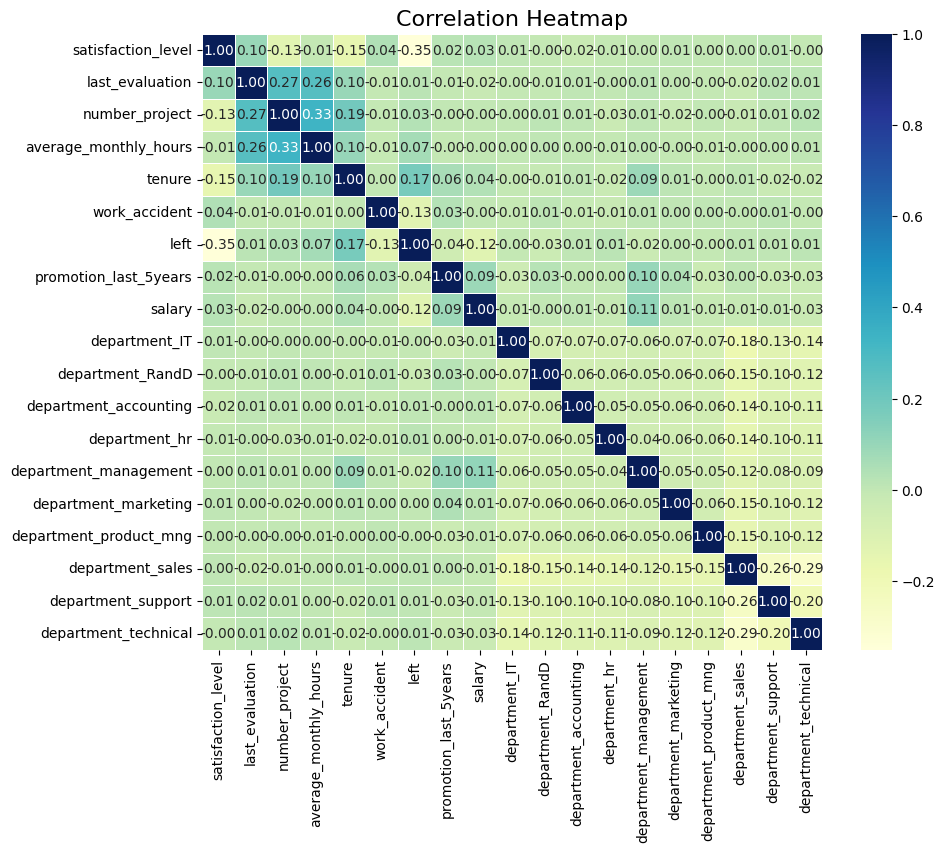

In [35]:
# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap with green tones
sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=0.5)

# Add a title to the heatmap
plt.title('Correlation Heatmap', fontsize=16)

# Show the plot
plt.show()

In [36]:
df_logreg = df_encoded.copy()
df_logreg = df_logreg[(df_logreg['tenure'] >= lower_bound) & (df_logreg['tenure'] <= upper_bound)]
df_logreg.head()


satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   
5       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   
5             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

In [40]:
#Dropping the 'left' attribute

X = df_logreg.drop(['left'], axis=1)
y = df_logreg['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)

logreg_clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
y_pred = logreg_clf.predict(X_test)

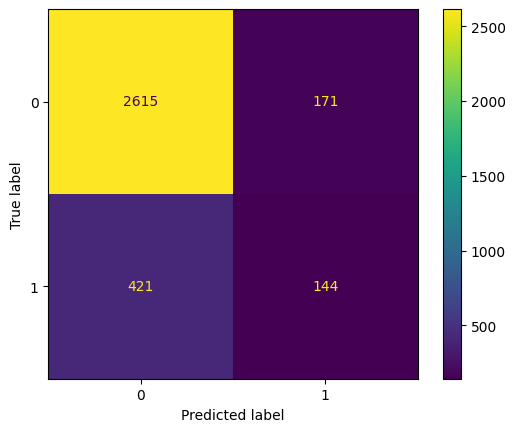

In [41]:
log_cm = confusion_matrix(y_test, y_pred, labels=logreg_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=logreg_clf.classes_)

log_disp.plot()
plt.show()

In [42]:
target_names = ['Predicted not leaving', 'Predicted leaving']
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

Predicted not leaving       0.86      0.94      0.90      2786
    Predicted leaving       0.46      0.25      0.33       565

             accuracy                           0.82      3351
            macro avg       0.66      0.60      0.61      3351
         weighted avg       0.79      0.82      0.80      3351



In [43]:
roc_auc_score(y_true=y_test, y_score=logreg_clf.predict_proba(X_test)[:, 1])

np.float64(0.8808791111054641)

In [44]:
result = pd.DataFrame({'model': ['Logistic Regression'],
					   'accuracy': [accuracy_score(y_test, y_pred)],
					   'precision': [precision_score(y_test, y_pred)],
					   'recall': [recall_score(y_test, y_pred)],
					   'f1': [f1_score(y_test, y_pred)],
					   'roc_auc': [roc_auc_score(y_true=y_test, y_score=logreg_clf.predict_proba(X_test)[:, 1])]})
result

model  accuracy  precision    recall        f1   roc_auc
0  Logistic Regression  0.823336   0.457143  0.254867  0.327273  0.880879

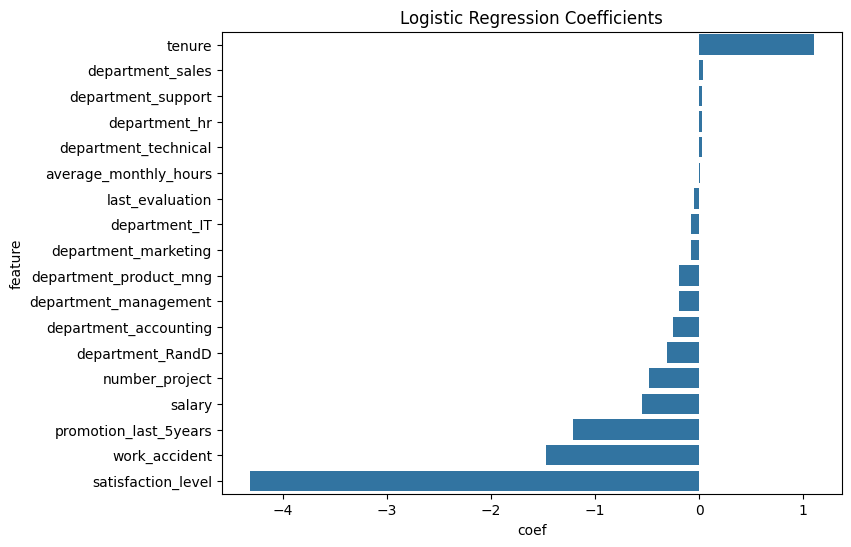

In [64]:
# make coefs dataframe and plot
coefs = pd.DataFrame({'feature': X_train.columns,
					  'coef': logreg_clf.coef_[0]})
coefs = coefs.sort_values(by='coef', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=coefs, x='coef', y='feature')
plt.title('Logistic Regression Coefficients')

plt.show()


In [46]:
%%time
#Developing tree based classification model using Random Forest

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

cv_params = {'n_estimators' : [50,100], 
             'max_depth' : [10,50],        
             'min_samples_leaf' : [0.5,1], 
             'min_samples_split' : [0.001, 0.01],
             'max_features' : ["sqrt"], 
             'max_samples' : [.5,.9]}

rf = RandomForestClassifier(random_state = 0)
rf_val = GridSearchCV(rf, cv_params, cv=5, refit='f1', n_jobs = -1, verbose = 1)


CPU times: total: 0 ns
Wall time: 3.42 ms


In [47]:
%%time
rf_val.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: total: 2.14 s
Wall time: 33.3 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 50], 'max_features': ['sqrt'],
                         'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [0.5, 1],
                         'min_samples_split': [0.001, 0.01],
                         'n_estimators': [50, 100]},
             refit='f1', verbose=1)

In [48]:
rf_val.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 0.001,
 'n_estimators': 50}

In [49]:
rf_opt = RandomForestClassifier(n_estimators = 100, max_depth = 50, 
                                min_samples_leaf = 1, min_samples_split = 0.01,
                                max_features="sqrt", max_samples = 0.9, random_state = 0)
rf_opt.fit(X_train, y_train)
y_pred = rf_opt.predict(X_test)

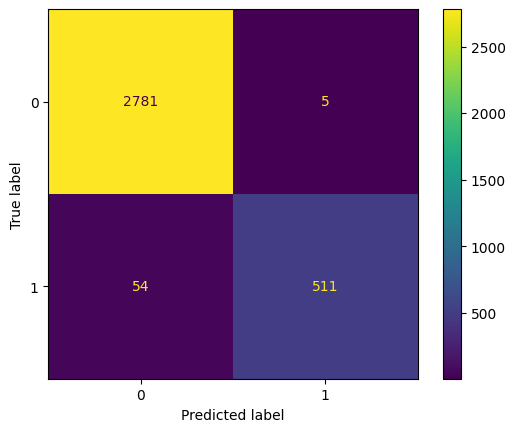

In [50]:
rf_cm = confusion_matrix(y_test, y_pred, labels=rf_opt.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, 
								 display_labels=rf_opt.classes_)
rf_disp.plot()
plt.show()

In [51]:
target_names = ['Predicted not leaving', 'Predicted leaving']
print(classification_report(y_test, y_pred, target_names=target_names))


                       precision    recall  f1-score   support

Predicted not leaving       0.98      1.00      0.99      2786
    Predicted leaving       0.99      0.90      0.95       565

             accuracy                           0.98      3351
            macro avg       0.99      0.95      0.97      3351
         weighted avg       0.98      0.98      0.98      3351



In [52]:
roc_auc_score(y_true=y_test, y_score=rf_opt.predict_proba(X_test)[:, 1])

np.float64(0.9851202917241073)

In [53]:
temp = pd.DataFrame({'model': ['Random Forest'],
					   'accuracy': [accuracy_score(y_test, y_pred)],
					   'precision': [precision_score(y_test, y_pred)],
					   'recall': [recall_score(y_test, y_pred)],
					   'f1': [f1_score(y_test, y_pred)],
					   'roc_auc': [roc_auc_score(y_true=y_test, y_score=rf_opt.predict_proba(X_test)[:, 1])]})

result = pd.concat([result, temp], axis=0).sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
result

model  accuracy  precision    recall        f1   roc_auc
0        Random Forest  0.982393   0.990310  0.904425  0.945421  0.985120
1  Logistic Regression  0.823336   0.457143  0.254867  0.327273  0.880879

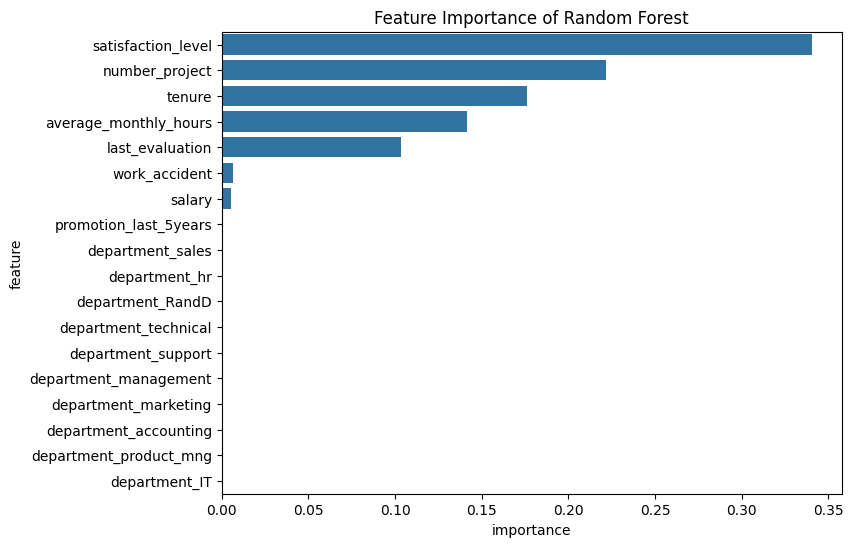

In [54]:
# feature importance of random forest
temp = pd.DataFrame({'feature': X_train.columns, 
					 'importance': rf_opt.feature_importances_})
temp.sort_values(by='importance', ascending=False, inplace=True)
temp.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=temp['importance'], y=temp['feature'])
plt.title('Feature Importance of Random Forest')

plt.show()

In [55]:
#Let us try XGBoost
cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }


xgb = XGBClassifier(random_state = 0)
xgb_cv = GridSearchCV(xgb, cv_params, cv=5, refit='f1', n_jobs=-1, verbose=1)

In [56]:
%%time
xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\Daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: total: 1.86 s
Wall time: 11.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', verbose=1)

In [57]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

In [58]:
xgb_opt = XGBClassifier(n_estimators = 15, max_depth = 6,
                        learning_rate=0.1, min_child_weight=3,
						colsample_bytree=0.7,
                        subsample=0.7, random_state = 0)
xgb_opt.fit(X_train, y_train)
y_pred = xgb_opt.predict(X_test)

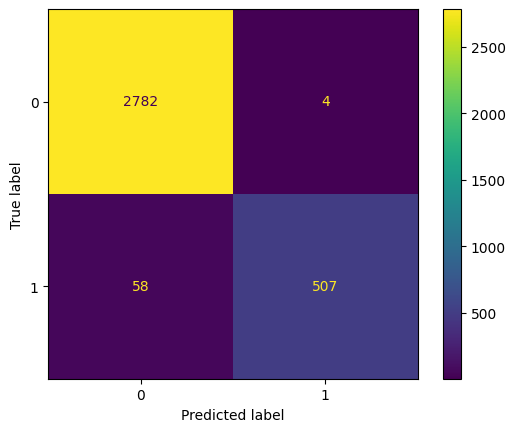

In [59]:
xgb_cm = confusion_matrix(y_test, y_pred, labels=xgb_opt.classes_)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, 
								 display_labels=xgb_opt.classes_)

xgb_disp.plot()
plt.show()

In [60]:
target_names = ['Predicted not leaving', 'Predicted leaving']
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

Predicted not leaving       0.98      1.00      0.99      2786
    Predicted leaving       0.99      0.90      0.94       565

             accuracy                           0.98      3351
            macro avg       0.99      0.95      0.97      3351
         weighted avg       0.98      0.98      0.98      3351



In [61]:
roc_auc_score(y_true=y_test, y_score=xgb_opt.predict_proba(X_test)[:, 1])

np.float64(0.9830727594991392)

In [62]:
temp = pd.DataFrame({'model': ['XGBoost'],
					   'accuracy': [accuracy_score(y_test, y_pred)],
					   'precision': [precision_score(y_test, y_pred)],
					   'recall': [recall_score(y_test, y_pred)],
					   'f1': [f1_score(y_test, y_pred)],
					   'roc_auc': [roc_auc_score(y_true=y_test, y_score=xgb_opt.predict_proba(X_test)[:, 1])]})

result = pd.concat([result, temp], axis=0).sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
result


model  accuracy  precision    recall        f1   roc_auc
0        Random Forest  0.982393   0.990310  0.904425  0.945421  0.985120
1              XGBoost  0.981498   0.992172  0.897345  0.942379  0.983073
2  Logistic Regression  0.823336   0.457143  0.254867  0.327273  0.880879

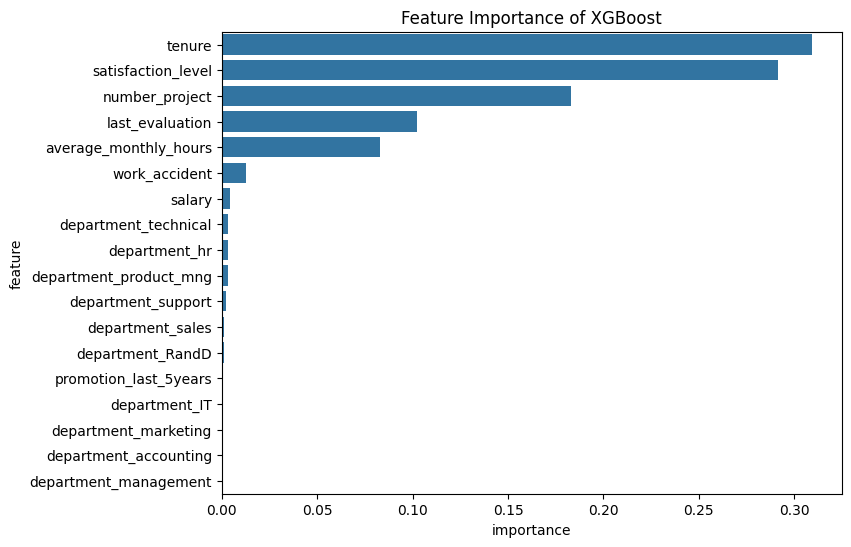

In [63]:
# feature importance of xgboost
temp = pd.DataFrame({'feature': X_train.columns, 
					 'importance': xgb_opt.feature_importances_})
temp.sort_values(by='importance', ascending=False, inplace=True)
temp.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=temp['importance'], y=temp['feature'])
plt.title('Feature Importance of XGBoost')

plt.show()


In [65]:
#The final result of all the modeling 
result

model  accuracy  precision    recall        f1   roc_auc
0        Random Forest  0.982393   0.990310  0.904425  0.945421  0.985120
1              XGBoost  0.981498   0.992172  0.897345  0.942379  0.983073
2  Logistic Regression  0.823336   0.457143  0.254867  0.327273  0.880879